# Gradient verification for the 2D - non reactive transport (diffusion + advection), permeablity inversion from head - density flow

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
import os
from pathlib import Path
import logging
import copy
import time
from typing import Dict, Generator, Iterable
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import nested_grid_plotter as ngp
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import LogNorm
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import numpy as np
from pyrtid.forward.models import VerticalAxis
import pandas as pd
from pyrtid.plot import plot_2d_grad_res_adj_vs_fd
import scipy as sp
import gstools as gs
from pyrtid.utils import NDArrayFloat
from pyrtid.utils import (
    get_normalized_mean_from_lognormal_params,
    get_normalized_std_from_lognormal_params,
    gen_random_ensemble,
    indices_to_node_number,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [3]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.9.0
INFO:root:nested_grid_plotter         = 1.1.2
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [5]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure transient density flow + transport (advection & diffusion) case in 2D.

In [6]:
nx = 21  # number of voxels along the x axis
ny = 8  # number of voxels along the y axis
nz = 1  # number of voxels along the y axis
# Give non regular dimensions to check if all is correct with mesh dimensions
dx = 8.43  # voxel dimension along the x axis
dy = 5.6
dz = 1.5  # voxel dimension along the y axis

duration_in_days = 3
duration_in_s = duration_in_days * 3600 * 24
dt_init = 3600 * 6  # timestep in seconds
dt_min = dt_init
dt_max = dt_init
c0 = 0  # general initial cocentration
# Hydro parameters
D0 = 1e-8  # general initial diffusion coefficient [m2/s]
k0 = 1e-3  # general permeability
w0 = 0.23  # general porosity [fraction]
# Chemistry parameters
c0 = 0.0  # general initial concentration [molal]
c_inj = 1  # molal

storage_coefficient: float = 1e-4

is_boundary_conditions = True

initial_head_in_m = 100  # m
cst_head_left = 120.0  # 9.3  # m
cst_head_right = 90.0  # -5.5  # m

flow_regime = "transient"

crank_flow = 1.0
crank_diff = 1.0
crank_adv = 1.0

is_gravity = True
vertical_axis = VerticalAxis.DZ


# Values for the x axis ()meters
x_positions_in_meters: NDArrayFloat = np.arange(nx) * dx + dx / 2

In [7]:
x_positions_in_meters

array([  4.215,  12.645,  21.075,  29.505,  37.935,  46.365,  54.795,
        63.225,  71.655,  80.085,  88.515,  96.945, 105.375, 113.805,
       122.235, 130.665, 139.095, 147.525, 155.955, 164.385, 172.815])

- Three observation wells

In [8]:
well_length = 1.0
production_locations = [(6, 3, 0), (14, 3, 0)]
injection_locations = [(2, 6, 0), (10, 6, 0), (18, 6, 0)]

- Create an initial "bumped" reference distribution for the permeability, and a flat one for the initial estimation.

In [9]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 19

min_val = 1e-7
max_val = 1e-3
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
meanlog = (max_val + min_val) / 2.0
stdevlog = (max_val - min_val) / 2.0  # std ~ 1/6 of the distribution interval
len_scale: float = 2.0

mean = get_normalized_mean_from_lognormal_params(meanlog, stdevlog)
stdev = get_normalized_std_from_lognormal_params(meanlog, stdevlog)

perm_reference = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    normalizer=gs.normalizer.LogNormal,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    nz=nz,
    seed=seed,
)[0, :, :, 0]

perm_estimate = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    normalizer=gs.normalizer.LogNormal,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    nz=nz,
    # seed=2365,
    seed=2364,
)[0, :, :, 0]

# Initial estimate = an homogeneous value
# perm_estimate = np.ones((nx, ny)) * 2e-4  # m2/s

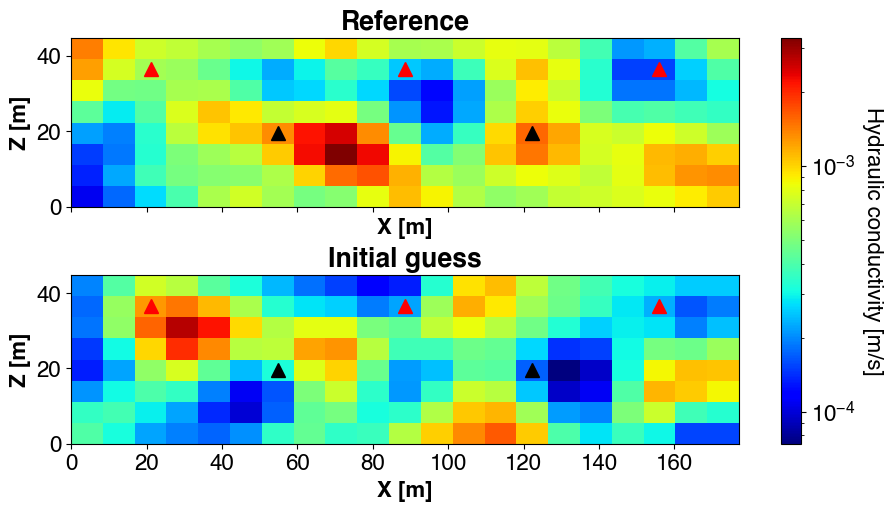

In [10]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax1-2"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": perm_reference,
        "Initial guess": perm_estimate,
    },
    cbar_title="Hydraulic conductivity [m/s]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "norm": LogNorm(),
        "aspect": "equal",
    },
    xlabel="X [m]",
    ylabel="Z [m]",
)

# plotter.subfigs["fig0"].suptitle("Permeability field [m/s]", fontweight="bold")

for ax in plotter.ax_dict.values():
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="prod wells",
            marker="^",
            markersize=10,
            c="black",
            linestyle="none",
        )

    for well_pos in injection_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="inj wells",
            marker="^",
            markersize=10,
            c="red",
            linestyle="none",
        )

fname = "ref_vs_ig_hc_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Create the flowrates for the wells: 12 m3/h decreasing following an exponential... for the producers with a balanced injection (2 m3/h per associated cell for the injectors).

In [11]:
def gen_flowrates(amplitude: float, coef: float, nt: int, dt: float) -> NDArrayFloat:
    """Generate flowrates with a given amplitude and decrease coefficient.

    Parameters
    ----------
    amplitude : float
        Amplitude in m3/h.
    coef : float
        Decrease coefficient.
    nt : int
        Number of timesteps
    dt : float
        Timesteps.

    Returns
    -------
    np.ndarray
        The flowrates.
    """
    return amplitude * np.exp(coef * np.arange(nt) * dt)

- Generate a flowrates with an initial amplitude at 1 m3/h and plot it

Text(0.5, 0, 'time [d]')

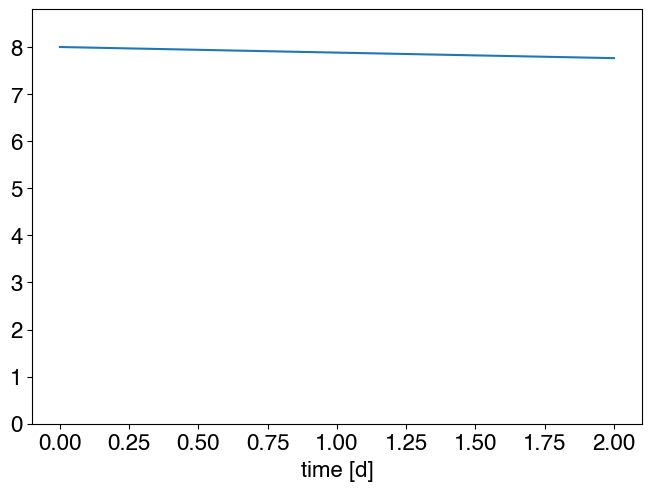

In [12]:
init_prod_flowrates = 8.0  # m3/s
# nt+1 because we consider the initial state too
flowrates = init_prod_flowrates * gen_flowrates(
    1.0, -0.015, duration_in_days, dt=1
)  # m3/s

plt.plot(np.arange(duration_in_days), flowrates)
plt.ylim(0.0, init_prod_flowrates * 1.1)
plt.xlabel("time [d]")

### Forward problem definition in PyRTID

In [13]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy, dz=dz)
fl_params = dmfwd.FlowParameters(
    permeability=k0,
    storage_coefficient=storage_coefficient,
    regime={
        "stationary": dmfwd.FlowRegime.STATIONARY,
        "transient": dmfwd.FlowRegime.TRANSIENT,
    }[flow_regime],
    crank_nicolson=crank_flow,
    is_gravity=is_gravity,
    vertical_axis=vertical_axis,
)
tr_params = dmfwd.TransportParameters(
    diffusion=D0,
    porosity=w0,
    crank_nicolson_diffusion=crank_diff,
    crank_nicolson_advection=crank_adv,
)
gch_params = dmfwd.GeochemicalParameters(conc=c0)

base_model = dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

# Add a non homogneous storage coefficient field
# base_model.fl_model.storage_coefficient *= np.abs(1 + np.random.default_rng(2024).normal(loc=0, scale=0.2, size=(nx, ny)))

- Add boundary conditions

In [14]:
base_model.fl_model.set_initial_head(initial_head_in_m)

# Boundary conditions
span_left = (slice(0, 1), slice(None))
base_model.fl_model.set_initial_head(cst_head_left, span=span_left)
span_right = (slice(nx - 1, nx), slice(None))
base_model.fl_model.set_initial_head(cst_head_right, span=span_right)
if is_boundary_conditions:
    base_model.add_boundary_conditions(dmfwd.ConstantHead(span=span_left))
    base_model.add_boundary_conditions(dmfwd.ConstantHead(span=span_right))

- Add source and sink terms

In [15]:
prod_flw = -flowrates / 3600  # m3/h to m3/s
fw_times_in_s = (
    np.arange(stop=duration_in_days, start=0, dtype=np.float_) * 3600 * 24
)  # in seconds

# two successive pumping on days 1 and 2
for loc in production_locations:
    sink_term = dmfwd.SourceTerm(
        f"producer loc # {loc}",
        node_ids=np.array(indices_to_node_number(loc[0], nx=nx, iy=loc[1])),
        # pumping on 1 day
        times=fw_times_in_s,
        flowrates=prod_flw,
        concentrations=np.zeros((*fw_times_in_s.shape, 2)),
    )
    base_model.add_src_term(sink_term)

n_prod_linked_list = [1, 2, 1]

_inj = np.zeros((*fw_times_in_s.shape, 2))
_inj[0, :] = c_inj

# three successive injections on days 3, 4 and 5
for count_inj, loc in enumerate(injection_locations):
    source_term = dmfwd.SourceTerm(
        "injector loc # {loc}",
        node_ids=np.array(indices_to_node_number(loc[0], nx=nx, iy=loc[1])),
        times=fw_times_in_s,
        flowrates=-n_prod_linked_list[count_inj] * prod_flw / 2.0,
        concentrations=_inj,  # injection concentration
    )
    base_model.add_src_term(source_term)

- Create two models

In [16]:
model_reference = copy.deepcopy(base_model)
model_estimate = copy.deepcopy(base_model)
# Reference
model_reference.fl_model.permeability = perm_reference.reshape(nx, ny)
# Estimated diffusion
model_estimate.fl_model.permeability = perm_estimate.reshape(nx, ny)
model_reference.tr_model.set_initial_conc(c0)
model_estimate.tr_model.set_initial_conc(c0)

- Run the models

In [17]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve(is_verbose=True)

INFO:root:max-coupling error at it = 1-1:3.138862190166236e-07
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 2-1:3.1676940071001525e-07
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 3-1:3.1526777555246355e-07
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 4-1:3.1275059886315404e-07
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 5-1:2.3983133989879946e-07
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 6-1:2.5930303004795263e-07
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 7-1:2.5659607327810363e-07
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 8-1:2.3786712555207146e-07
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 9-1:3.138644828482029e-07
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 10-1:3.146277203214254e-07
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 11-1:

In [18]:
solver_estimate = dmfwd.ForwardSolver(model_estimate)
solver_estimate.solve()

### Forward problem results

### Head, pressure, and darcy velocities

- spatial evolution of heads

In [19]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"]],
            sharey=True,
            sharex=True,
        )
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference (PyRTID)": model_reference.fl_model.head[:, :, :],
        "Initial guess (PyRTID)": model_estimate.fl_model.head[:, :, :],
    },
    cbar_title="Head [m]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
    nb_frames=nb_frames,
)

plotter.subfigs["fig0"].suptitle("Head field [m]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "head_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Pressure evolution

In [20]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"]],
            sharey=True,
            sharex=True,
        )
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference (PyRTID)": model_reference.fl_model.get_pressure_bar()[:, :, :],
        "Initial guess (PyRTID)": model_estimate.fl_model.get_pressure_bar()[:, :, :],
    },
    cbar_title="Pressure [bar]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
    nb_frames=nb_frames,
)

plotter.subfigs["fig0"].suptitle("Pressure [bar]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "pressure_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Concentration evolution

In [21]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"]],
            sharey=True,
            sharex=True,
        )
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)


plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference (PyRTID)": model_reference.tr_model.conc[:, :, :],
        "Initial guess (PyRTID)": model_estimate.tr_model.conc[:, :, :],
    },
    cbar_title="Tracer concentration [molal]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Z [m]",
    nb_frames=nb_frames,
)

for ax in plotter.ax_dict.values():
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="prod wells",
            marker="^",
            markersize=10,
            c="violet",
            linestyle="none",
        )

    for well_pos in injection_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

plotter.subfigs["fig0"].suptitle("Tracer concentration [molal]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "concentration_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


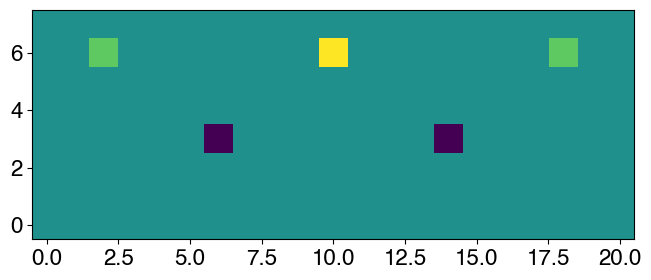

In [22]:
plt.imshow(model_estimate.fl_model.unitflow[:, :, 3].T, origin="lower")

- Density evolution

In [23]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax1-2"]], sharey=True, sharex=True)
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference": model_reference.tr_model.density[:, :, :],
        "Initial guess": model_estimate.tr_model.density[:, :, :],
    },
    cbar_title="Tracer concentration [molal]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Z [m]",
    nb_frames=nb_frames,
)

for ax in plotter.ax_dict.values():
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="prod wells",
            marker="^",
            markersize=10,
            c="violet",
            linestyle="none",
        )

    for well_pos in injection_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

plotter.subfigs["fig0"].suptitle("Density [kg/m3]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("density_reference_vs_initial_guess_animated.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


### Head and pressure at wells

We sample heads in the first half of the simulation, and pressure in the second half of the simulation so we can test the implementation with both. We also add a small overlap (2 observations).


In [24]:
freq_measure_in_d = 0.5  # one measure every two days
n_sampled_days = max(duration_in_days / freq_measure_in_d, 4)

obs_times_in_s = np.arange(n_sampled_days) * 3600 * 24 * freq_measure_in_d
obs_times_in_s = obs_times_in_s[
    obs_times_in_s <= model_estimate.time_params.time_elapsed
]
logging.info(f"obs_times_in_s_head = {obs_times_in_s}")

INFO:root:obs_times_in_s_head = [     0.  43200.  86400. 129600. 172800. 216000.]


In [25]:
noise_std_head: float = 0.5  # This is an absolute value in m
noise_std_pressure: float = 1.0 * 1e3  # This is an absolute value in Pa
noise_std_conc: float = 0.01  # This is an absolute value in m
noise_std_density: float = 1  # This is an absolute value in m


def get_white_noise(shape: Iterable[int], noise_std: float) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise_head: NDArrayFloat = get_white_noise(
    (len(production_locations), obs_times_in_s.size), noise_std_head
)
obs_noise_pressure: NDArrayFloat = get_white_noise(
    (len(production_locations), obs_times_in_s.size), noise_std_pressure
)
obs_noise_conc: NDArrayFloat = get_white_noise(
    (len(production_locations), obs_times_in_s.size), noise_std_conc
)
obs_noise_density: NDArrayFloat = get_white_noise(
    (len(production_locations), obs_times_in_s.size), noise_std_density
)

In [26]:
production_locations

[(6, 3, 0), (14, 3, 0)]

- Head

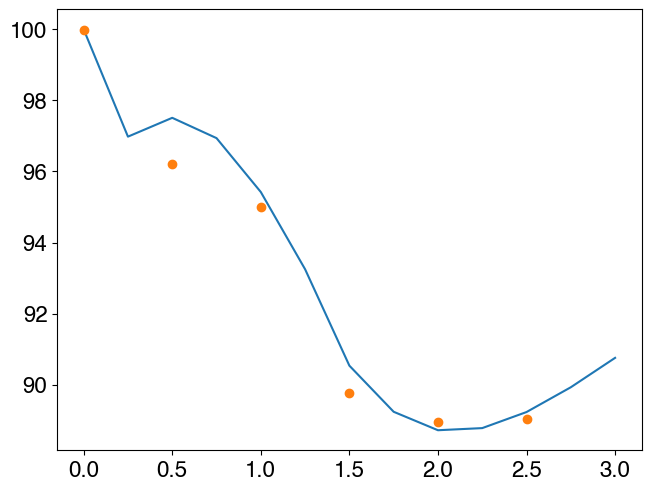

In [27]:
all_times = model_estimate.time_params.times

obs_values_head = np.zeros((len(production_locations), obs_times_in_s.size))

for count, (ix, iy, iz) in enumerate(production_locations):
    # interpolate the values
    obs_values_head[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.fl_model.head[ix, iy, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise_head[count, :]
    )

count = 1

ix, iy, iz = production_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.fl_model.head[ix, iy, :])
plt.plot(
    obs_times_in_s / 3600 / 24,
    obs_values_head[count],
    marker="o",
    linestyle="none",
)

- Pressure

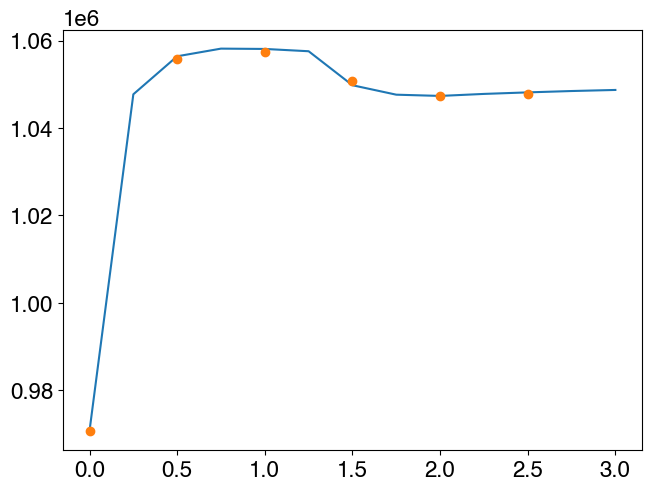

In [28]:
obs_values_pressure = np.zeros((len(production_locations), obs_times_in_s.size))

for count, (ix, iy, iz) in enumerate(production_locations):
    # interpolate the values
    obs_values_pressure[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.fl_model.pressure[ix, iy, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise_pressure[count, :]
    )

count = 0

ix, iy, iz = production_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.fl_model.pressure[ix, iy, :])
plt.plot(
    obs_times_in_s / 3600 / 24,
    obs_values_pressure[count],
    marker="o",
    linestyle="none",
)

- Density

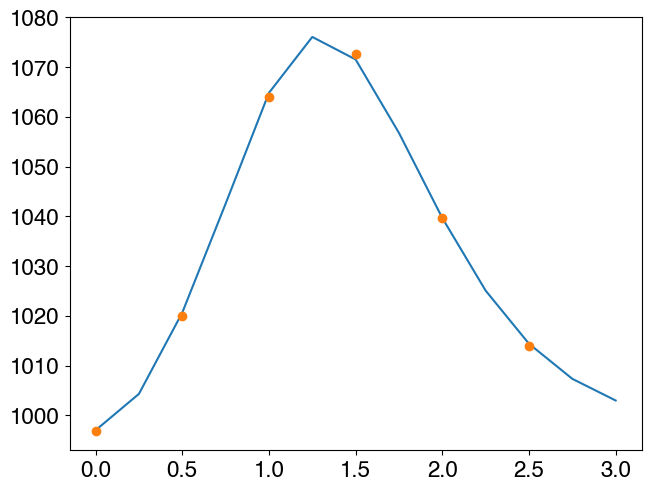

In [29]:
obs_values_density = np.zeros((len(production_locations), obs_times_in_s.size))

for count, (ix, iy, iz) in enumerate(production_locations):
    # interpolate the values
    obs_values_density[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.tr_model.density[ix, iy, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise_density[count, :]
    )

count = 0

ix, iy, iz = production_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.tr_model.density[ix, iy, :])
plt.plot(
    obs_times_in_s / 3600 / 24,
    obs_values_density[count],
    marker="o",
    linestyle="none",
)

- Conc

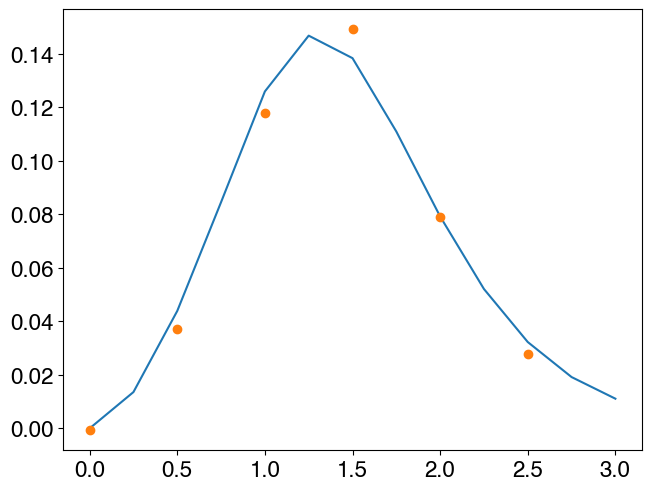

In [30]:
obs_values_conc = np.zeros((len(production_locations), obs_times_in_s.size))

for count, (ix, iy, iz) in enumerate(production_locations):
    # interpolate the values
    obs_values_conc[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.tr_model.conc[ix, iy, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise_conc[count, :]
    )

count = 0

ix, iy, iz = production_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.tr_model.conc[ix, iy, :])
plt.plot(
    obs_times_in_s / 3600 / 24,
    obs_values_conc[count],
    marker="o",
    linestyle="none",
)

- Forward variables at the producer locations

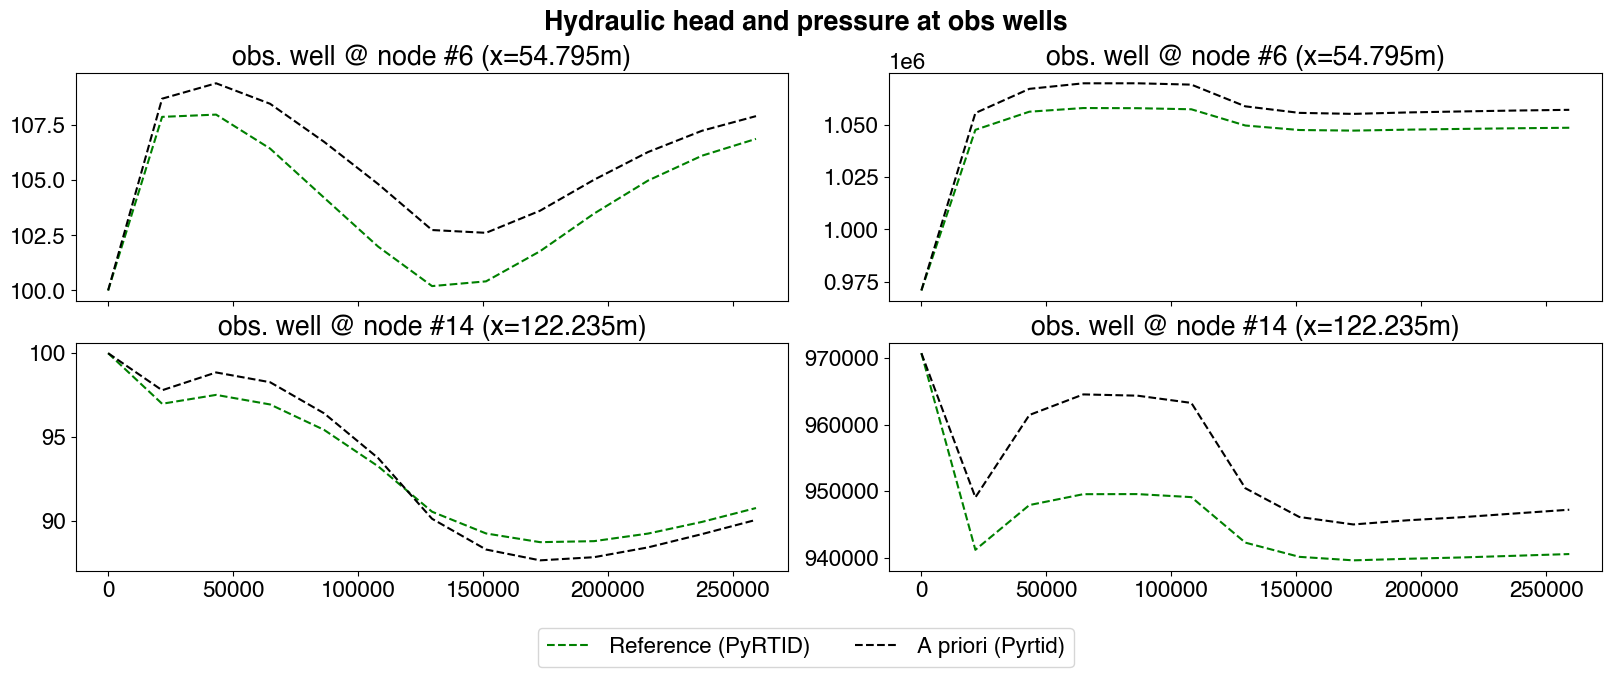

In [31]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (16, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2"], ["ax2-1", "ax2-2"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, (ix, iy, iz) in enumerate(production_locations):
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy
    z = (iz + 0.5) * dz

    # Head
    ax = plotter.get_axis(f"ax{i + 1}-1")
    obs_well_name = f"obs. well @ node #{ix} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.time_params.times,
        model_reference.fl_model.head[ix, iy, :],
        label="Reference (PyRTID)",
        c="g",
        linestyle="--",
    )
    ax.plot(
        model_estimate.time_params.times,
        model_estimate.fl_model.head[ix, iy, :],
        label="A priori (Pyrtid)",
        c="k",
        linestyle="--",
    )

    # Pressure
    ax = plotter.get_axis(f"ax{i + 1}-2")
    obs_well_name = f"obs. well @ node #{ix} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.time_params.times,
        model_reference.fl_model.pressure[ix, iy, :],
        label="Reference (PyRTID)",
        c="g",
        linestyle="--",
    )
    ax.plot(
        model_estimate.time_params.times,
        model_estimate.fl_model.pressure[ix, iy, :],
        label="A priori (Pyrtid)",
        c="k",
        linestyle="--",
    )

    # ax.plot(
    #     ,
    #     model_reference.fl_model.head[ix, iy, :],
    #     label="Reference (PyRTID)",
    #     c="b",
    #     linestyle="--",
    # )
    # ax.plot(
    #     grid_sample_times,
    #     model_estimate.fl_model.head[ix, iy, :],
    #     label="A priori (PyRTID)",
    #     c="r",
    #     linestyle="--",
    # )

plotter.fig.suptitle("Hydraulic head and pressure at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "head_and_pressure_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Concentration at producers

Several criteria can be used to judge whether the optimization should be stopped. In the context of quasi-newtons, in addition to the maximum number of iterations or evaluations of the objective function, which reflect physical computational limitations, there are four main stopping criteria. They are based on the absolute value of the $\mathcal{J}$, the variation of $\mathcal{J}$ between two iterations, the change in $\mathbf{s}$ between two iterations, and the norm of $\dfrac{\partial \mathcal{J}}{\partial \mathbf{s}}$  between two iterations. These criteria are described below and will be used in \cref{chapter7} and in the numerical applications of \cref{chapter5,chapter6,chapter7,chapter8}. 

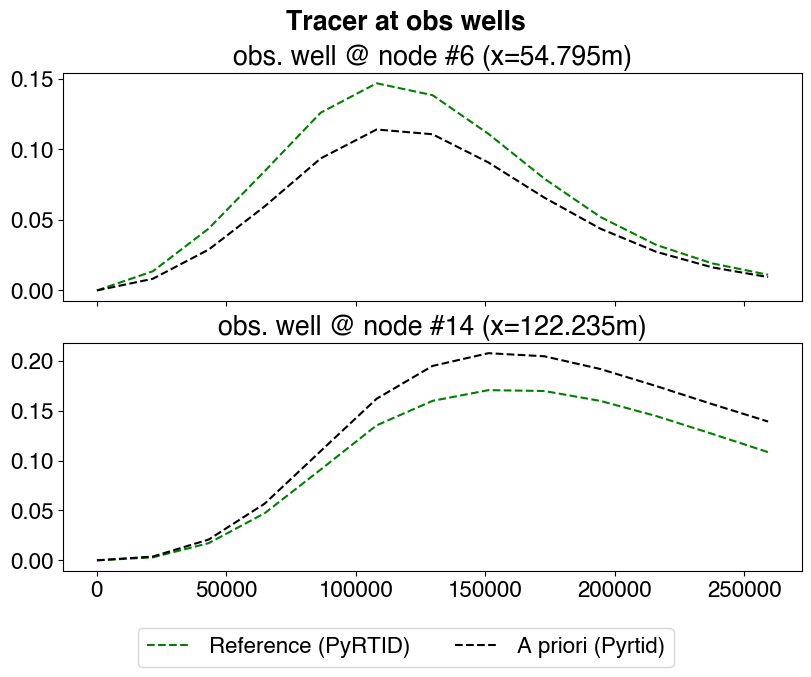

In [32]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, (ix, iy, iz) in enumerate(production_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy
    z = (iz + 0.5) * dz
    obs_well_name = f"obs. well @ node #{ix} (x={x}m)"

    ax.set_title(obs_well_name)

    ax.plot(
        model_reference.time_params.times,
        model_reference.tr_model.conc[ix, iy, :],
        label="Reference (PyRTID)",
        c="g",
        linestyle="--",
    )
    ax.plot(
        model_estimate.time_params.times,
        model_estimate.tr_model.conc[ix, iy, :],
        label="A priori (Pyrtid)",
        c="k",
        linestyle="--",
    )


plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Gradient with respect to the permeability

In [33]:
param_k = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    # /10 to avoid finite differences fail because of bounds clipping
    lbounds=min_val / 10,
    # * 10 to avoid finite differences fail because of bounds clipping
    ubounds=max_val * 10,
    preconditioner=dminv.LogTransform(),
    # regularizators=dminv.regularization.TikhonovRegularizator(
    #     dx=dx, dy=dy, preconditioner=dminv.LogTransform()
    # ),
)

observables = []
for i, (ix, iy, iz) in enumerate(production_locations):
    node_id = indices_to_node_number(ix, nx=nx, iy=iy, ny=ny)
    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.HEAD,
            node_indices=node_id,
            times=obs_times_in_s,
            values=obs_values_head[i],
            uncertainties=noise_std_head,
        )
    )

    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.PRESSURE,
            node_indices=node_id,
            times=obs_times_in_s,
            values=obs_values_pressure[i],
            uncertainties=noise_std_pressure,
        )
    )

    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.CONCENTRATION,
            node_indices=node_id,
            times=obs_times_in_s,
            values=obs_values_conc[i],
            uncertainties=noise_std_conc,
            sp=0,
        )
    )

    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.DENSITY,
            node_indices=node_id,
            times=obs_times_in_s,
            values=obs_values_density[i],
            uncertainties=noise_std_density,
        )
    )

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-15,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param_k, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

executor.eval_scaled_loss(param_k.preconditioner(param_k.values))
is_grad_ok = executor.is_adjoint_gradient_correct(max_workers=4, is_verbose=False)

INFO:root:- Running forward model # 1


INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 1596.7701089483278
INFO:root:Loss (obs fit) / Nobs = 33.26604393642349
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.0006262642282667884
INFO:root:Loss (scaled)         = 1.0



In [34]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


In [35]:
scaling_factor = executor.inv_model.scaling_factor

- Plot the gradients

In [36]:
import copy
import warnings
from typing import List, Optional

import numpy as np
from pyrtid.forward.flow_solver import get_rhomean, get_rhomean2
from pyrtid.forward import ForwardModel, ForwardSolver
from pyrtid.forward.models import GRAVITY, WATER_DENSITY, FlowRegime, VerticalAxis
from pyrtid.inverse.adjoint import AdjointModel, AdjointSolver
from pyrtid.inverse.adjoint.aflow_solver import (
    get_adjoint_transport_src_terms,
    make_initial_adj_flow_matrices,
)
from pyrtid.inverse.adjoint.ageochem_solver import ddMdimmobprev
from pyrtid.inverse.loss_function import eval_model_loss_function
from pyrtid.inverse.obs import Observable, Observables
from pyrtid.inverse.params import (
    AdjustableParameter,
    AdjustableParameters,
    ParameterName,
    get_parameter_values_from_model,
    update_model_with_parameters_values,
    update_parameters_from_model,
)
from pyrtid.utils import StrEnum, finite_gradient, is_all_close
from pyrtid.utils.means import arithmetic_mean, dxi_harmonic_mean, harmonic_mean
from pyrtid.utils.types import NDArrayFloat, object_or_object_sequence_to_list


def _get_perm_gradient_from_darcy_eq_density(
    fwd_model: ForwardModel, adj_model: AdjointModel
) -> NDArrayFloat:
    """
    Compute the gradient with respect to the permeability using mob observations.

    Mob are the mobile concentrations.

    Parameters
    ----------
    fwd_model : ForwardModel
        The forward model which contains all forward variables and parameters.
    adj_model : AdjointModel
        The adjoint model which contains all adjoint variables and parameters.

    Returns
    -------
    NDArrayFloat
        Gradient with respect to the permeability using mob observations.
    """
    shape = (fwd_model.geometry.nx, fwd_model.geometry.ny, fwd_model.time_params.nt)
    permeability = fwd_model.fl_model.permeability

    pressure = fwd_model.fl_model.pressure
    grad = np.zeros_like(pressure)

    if fwd_model.geometry.nx > 1:
        a_u_darcy_x = adj_model.a_fl_model.a_u_darcy_x[1:-1, :, :]

        if fwd_model.fl_model.vertical_axis == VerticalAxis.DX:
            rho_ij_g_x = (
                get_rhomean2(
                    fwd_model.geometry,
                    fwd_model.tr_model,
                    axis=0,
                    time_index=slice(0, -1),
                    is_flatten=False,
                )[:-1]
                * GRAVITY
            )
        else:
            rho_ij_g_x = 0.0

        # Consider the x axis
        # Forward scheme
        dpressure_fx = np.zeros(shape)
        dpressure_fx[:-1, :, 1:] += (
            (
                (pressure[1:, :, 1:] - pressure[:-1, :, 1:]) / fwd_model.geometry.dx
                + rho_ij_g_x
            )
            * dxi_harmonic_mean(permeability[:-1, :], permeability[1:, :])[
                :, :, np.newaxis
            ]
            * a_u_darcy_x[:, :, 1:]
        )

        # Bconckward scheme
        dpressure_bx = np.zeros(shape)
        dpressure_bx[1:, :, 1:] -= (
            (
                (pressure[:-1, :, 1:] - pressure[1:, :, 1:]) / fwd_model.geometry.dx
                - rho_ij_g_x
            )
            * dxi_harmonic_mean(permeability[1:, :], permeability[:-1, :])[
                :, :, np.newaxis
            ]
            * a_u_darcy_x[:, :, 1:]
        )

        # Gather the two schemes
        grad += (dpressure_fx + dpressure_bx) / GRAVITY / WATER_DENSITY

    # Consider the y axis for 2D cases
    if fwd_model.geometry.ny > 1:
        a_u_darcy_y = adj_model.a_fl_model.a_u_darcy_y[:, 1:-1, :]

        if fwd_model.fl_model.vertical_axis == VerticalAxis.DY:
            rho_ij_g_y = (
                get_rhomean2(
                    fwd_model.geometry,
                    fwd_model.tr_model,
                    axis=1,
                    time_index=slice(0, -1),
                    is_flatten=False,
                )[:, :-1]
                * GRAVITY
            )
        else:
            rho_ij_g_y = 0.0

        # Forward scheme
        dpressure_fy = np.zeros(shape)
        dpressure_fy[:, :-1, 1:] += (
            (
                (pressure[:, 1:, 1:] - pressure[:, :-1, 1:]) / fwd_model.geometry.dy
                + rho_ij_g_y
            )
            * dxi_harmonic_mean(permeability[:, :-1], permeability[:, 1:])[
                :, :, np.newaxis
            ]
            * a_u_darcy_y[:, :, 1:]
        )

        # Bconckward scheme
        dpressure_by = np.zeros(shape)
        dpressure_by[:, 1:, 1:] -= (
            (
                (pressure[:, :-1, 1:] - pressure[:, 1:, 1:]) / fwd_model.geometry.dy
                - rho_ij_g_y
            )
            * dxi_harmonic_mean(permeability[:, 1:], permeability[:, :-1])[
                :, :, np.newaxis
            ]
            * a_u_darcy_y[:, :, 1:]
        )
        # Gather the two schemes
        grad += (dpressure_fy + dpressure_by) / GRAVITY / WATER_DENSITY

    # We sum along the temporal axis
    return np.sum(grad, axis=-1)


def _get_perm_gradient_from_diffusivity_eq_density(
    fwd_model: ForwardModel, adj_model: AdjointModel
) -> NDArrayFloat:
    """
    Compute the gradient with respect to the permeability using head observations.

    Parameters
    ----------
    fwd_model : ForwardModel
        The forward model which contains all forward variables and parameters.
    adj_model : AdjointModel
        The adjoint model which contains all adjoint variables and parameters.

    Returns
    -------
    NDArrayFloat
        Gradient with respect to the permeability using head observations.
    """
    shape = (fwd_model.geometry.nx, fwd_model.geometry.ny, fwd_model.time_params.nt)
    permeability = fwd_model.fl_model.permeability

    if adj_model.a_fl_model.crank_nicolson is None:
        crank_flow: float = fwd_model.fl_model.crank_nicolson
    else:
        crank_flow = adj_model.a_fl_model.crank_nicolson

    pressure = fwd_model.fl_model.pressure
    head = fwd_model.fl_model.head
    apressure = adj_model.a_fl_model.a_pressure
    ma_apressure = np.zeros(apressure.shape)
    free_head_indices = fwd_model.fl_model.free_head_indices
    ma_apressure[free_head_indices[0], free_head_indices[1], :] = apressure[
        free_head_indices[0], free_head_indices[1], :
    ]
    grad = np.zeros(shape)

    # Consider the x axis
    if fwd_model.geometry.nx > 1:
        rhomean_x = get_rhomean2(
            fwd_model.geometry,
            fwd_model.tr_model,
            axis=0,
            time_index=slice(0, -1),
            is_flatten=False,
        )[:-1]
        rhomean_x2 = get_rhomean2(
            fwd_model.geometry,
            fwd_model.tr_model,
            axis=0,
            time_index=slice(0, -1),
            is_flatten=False,
        )[:-1]
        tmp = 0.0
        if fwd_model.fl_model.vertical_axis == VerticalAxis.DX:
            tmp = rhomean_x**2 * GRAVITY

        # Forward scheme
        dpressure_fx = np.zeros(shape)
        dpressure_fx[:-1, :, 1:] += (
            (
                (
                    crank_flow * (pressure[1:, :, 1:] - pressure[:-1, :, 1:])
                    + (1.0 - crank_flow)
                    * (pressure[1:, :, :-1] - pressure[:-1, :, :-1])
                )
                / fwd_model.geometry.dx
                * rhomean_x2
                + tmp
            )
            * dxi_harmonic_mean(permeability[:-1, :], permeability[1:, :])[
                :, :, np.newaxis
            ]
            / WATER_DENSITY
        )

        dapressure_fx = np.zeros(shape)
        dapressure_fx[:-1, :, :] += ma_apressure[1:, :, :] - ma_apressure[:-1, :, :]

        # Handle the stationary case
        if fwd_model.fl_model.regime == FlowRegime.STATIONARY:
            dpressure_fx[:-1, :, :1] += (
                (head[1:, :, :1] - head[:-1, :, :1])
                * dxi_harmonic_mean(permeability[:-1, :], permeability[1:, :])[
                    :, :, np.newaxis
                ]
                / fwd_model.geometry.dx
            )

        # Bheadkward scheme
        dpressure_bx = np.zeros(shape)
        dpressure_bx[1:, :, 1:] += (
            (
                (
                    crank_flow * (pressure[:-1, :, 1:] - pressure[1:, :, 1:])
                    + (1.0 - crank_flow)
                    * (pressure[:-1, :, :-1] - pressure[1:, :, :-1])
                )
                / fwd_model.geometry.dx
                * rhomean_x2
                - tmp
            )
            * dxi_harmonic_mean(permeability[1:, :], permeability[:-1, :])[
                :, :, np.newaxis
            ]
            / WATER_DENSITY
        )

        dapressure_bx = np.zeros(shape)
        dapressure_bx[1:, :, :] += ma_apressure[:-1, :, :] - ma_apressure[1:, :, :]

        # Handle the stationary case
        if fwd_model.fl_model.regime == FlowRegime.STATIONARY:
            dpressure_bx[1:, :, :1] += (
                (head[:-1, :, :1] - head[1:, :, :1])
                * dxi_harmonic_mean(permeability[1:, :], permeability[:-1, :])[
                    :, :, np.newaxis
                ]
                / fwd_model.geometry.dx
            )

        # Gather the two schemes
        grad += (
            dpressure_fx * dapressure_fx + dpressure_bx * dapressure_bx
        ) * fwd_model.geometry.gamma_ij_x

    # Consider the y axis for 2D cases
    if fwd_model.geometry.ny > 1:
        rhomean_y = get_rhomean2(
            fwd_model.geometry,
            fwd_model.tr_model,
            axis=1,
            time_index=slice(0, -1),
            is_flatten=False,
        )[:, :-1]
        rhomean_y2 = get_rhomean2(
            fwd_model.geometry,
            fwd_model.tr_model,
            axis=1,
            time_index=slice(0, -1),
            is_flatten=False,
        )[:, :-1]
        tmp = 0.0
        if fwd_model.fl_model.vertical_axis == VerticalAxis.DY:
            tmp = rhomean_y**2 * GRAVITY

        # Forward scheme
        dpressure_fy = np.zeros(shape)
        dpressure_fy[:, :-1, 1:] += (
            (
                (
                    crank_flow * (pressure[:, 1:, 1:] - pressure[:, :-1, 1:])
                    + (1.0 - crank_flow)
                    * (pressure[:, 1:, :-1] - pressure[:, :-1, :-1])
                )
                / fwd_model.geometry.dy
                * rhomean_y2
                + tmp
            )
            * dxi_harmonic_mean(permeability[:, :-1], permeability[:, 1:])[
                :, :, np.newaxis
            ]
            / WATER_DENSITY
        )

        dapressure_fy = np.zeros(shape)
        dapressure_fy[:, :-1, :] += ma_apressure[:, 1:, :] - ma_apressure[:, :-1, :]

        # Handle the stationary case
        if fwd_model.fl_model.regime == FlowRegime.STATIONARY:
            dpressure_fy[:, :-1, :1] += (
                (head[:, 1:, :1] - head[:, :-1, :1])
                * dxi_harmonic_mean(permeability[:, :-1], permeability[:, 1:])[
                    :, :, np.newaxis
                ]
                / fwd_model.geometry.dy
            )

        # Bheadkward scheme
        dpressure_by = np.zeros(shape)
        dpressure_by[:, 1:, 1:] += (
            (
                (
                    crank_flow * (pressure[:, :-1, 1:] - pressure[:, 1:, 1:])
                    + (1.0 - crank_flow)
                    * (pressure[:, :-1, :-1] - pressure[:, 1:, :-1])
                )
                / fwd_model.geometry.dy
                * rhomean_y2
                - tmp
            )
            * dxi_harmonic_mean(permeability[:, 1:], permeability[:, :-1])[
                :, :, np.newaxis
            ]
            / WATER_DENSITY
        )

        dapressure_by = np.zeros(shape)
        dapressure_by[:, 1:, :] += ma_apressure[:, :-1, :] - ma_apressure[:, 1:, :]
        # Handle the stationary case

        if fwd_model.fl_model.regime == FlowRegime.STATIONARY:
            dpressure_by[:, 1:, :1] += (
                ((head[:, :-1, :1] - head[:, 1:, :1]))
                * dxi_harmonic_mean(permeability[:, 1:], permeability[:, :-1])[
                    :, :, np.newaxis
                ]
                / fwd_model.geometry.dy
            )

        # Gather the two schemes
        grad += (
            dpressure_fy * dapressure_fy + dpressure_by * dapressure_by
        ) * fwd_model.geometry.gamma_ij_y

    # We sum along the temporal axis
    return np.sum(grad, axis=-1)


def get_permeability_adjoint_gradient(
    fwd_model: ForwardModel, adj_model: AdjointModel
) -> NDArrayFloat:
    """
    Compute the gradient of the objective function with respect to the permeability.

    Parameters
    ----------
    fwd_model : ForwardModel
        The forward model which contains all forward variables and parameters.
    adj_model : AdjointModel
        The adjoint model which contains all adjoint variables and parameters.

    Returns
    -------
    NDArrayFloat
        Gradient of the objective function with respect to the permeability.
    """
    grad = _get_perm_gradient_from_diffusivity_eq_density(
        fwd_model, adj_model
    ) + _get_perm_gradient_from_darcy_eq_density(fwd_model, adj_model)

    # Add the adjoint sources for initial time (t0)
    return grad + adj_model.a_fl_model.a_permeability_sources.getcol(
        0
    ).todense().reshape(grad.shape, order="F")

In [37]:
executor.eval_scaled_loss(param_k.preconditioner(param_k.values))

INFO:root:- Running forward model # 2
INFO:root:- Run # 2 over
INFO:root:Loss (obs fit)        = 1596.7701089483278
INFO:root:Loss (obs fit) / Nobs = 33.26604393642349
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.0006262642282667884
INFO:root:Loss (scaled)         = 1.0



1.0

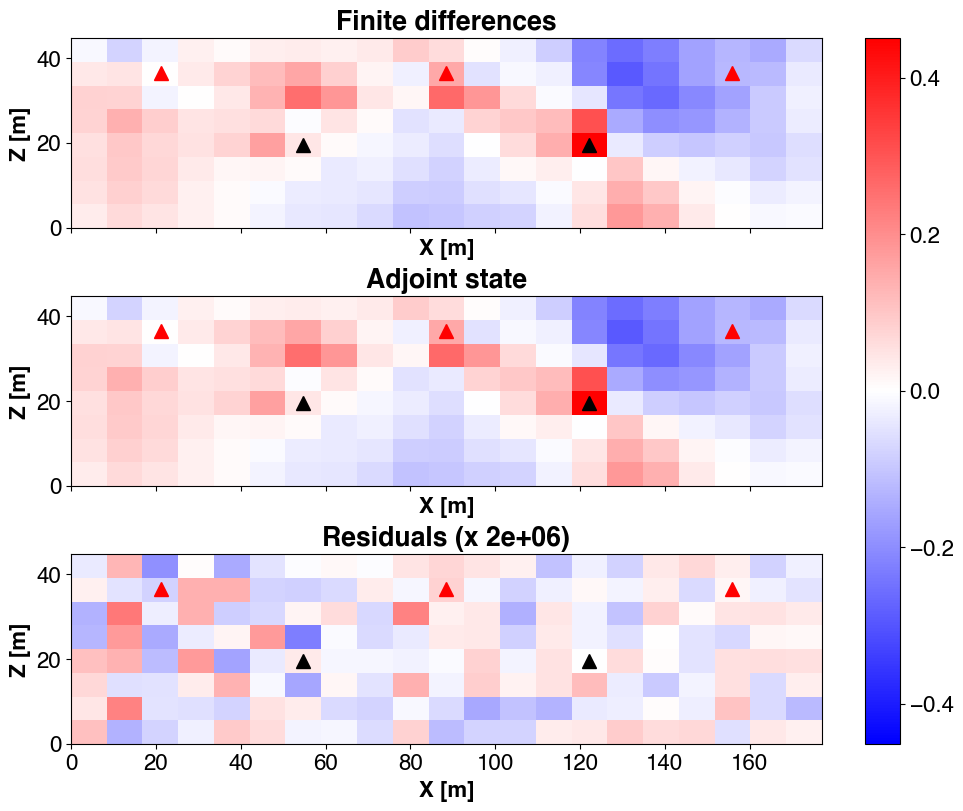

In [38]:
# from pyrtid.inverse.adjoint.gradients import _get_perm_gradient_from_diffusivity_eq_density, get_permeability_adjoint_gradient, compute_adjoint_gradient

test_grad = get_permeability_adjoint_gradient(executor.fwd_model, executor.adj_model)
param_values = get_parameter_values_from_model(executor.fwd_model, param_k)

plot_2d_grad_res_adj_vs_fd(
    # param_k.grad_adj_history[0].reshape(nx, ny, order="F") * scaling_factor,
    param_k.preconditioner.dbacktransform_vec(
        param_k.preconditioner(param_values), test_grad.reshape(nx, ny, order="F")
    )
    * scaling_factor,
    param_k.grad_fd_history[0].reshape(nx, ny, order="F") * scaling_factor,
    geometry,
    "perm",
    fig_save_path,
    prod_locations=production_locations,
    inj_locations=injection_locations,
)

In [40]:
np.count_nonzero(executor.adj_model.a_tr_model.a_density)

52

In [41]:
np.mean((param_k.grad_fd_history[0] - param_k.grad_adj_history[0]) * scaling_factor)

1.4109701651776384e-09

In [42]:
np.std((param_k.grad_fd_history[0] - param_k.grad_adj_history[0]) * scaling_factor)

3.9202761484673176e-08

## Gradient with respect to the storage coefficient

In [43]:
param_sc = dminv.AdjustableParameter(
    name=dminv.ParameterName.STORAGE_COEFFICIENT,
    # /10 to avoid finite differences fail because of bounds clipping
    lbounds=1e-10,
    # * 10 to avoid finite differences fail because of bounds clipping
    ubounds=1e-1,
    preconditioner=dminv.LogTransform(),
    # regularizators=dminv.regularization.TVRegularizator(
    #     dx=dx, dy=dy, preconditioner=dminv.LogTransform()
    # ),
)

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-15,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param_sc, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

executor.eval_scaled_loss(param_sc.preconditioner(param_sc.values))

is_grad_ok = executor.is_adjoint_gradient_correct(max_workers=4, is_verbose=False)

INFO:root:- Running forward model # 1


INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 1596.7701089485229
INFO:root:Loss (obs fit) / Nobs = 33.26604393642756
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.0006262642282667118
INFO:root:Loss (scaled)         = 1.0



In [44]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


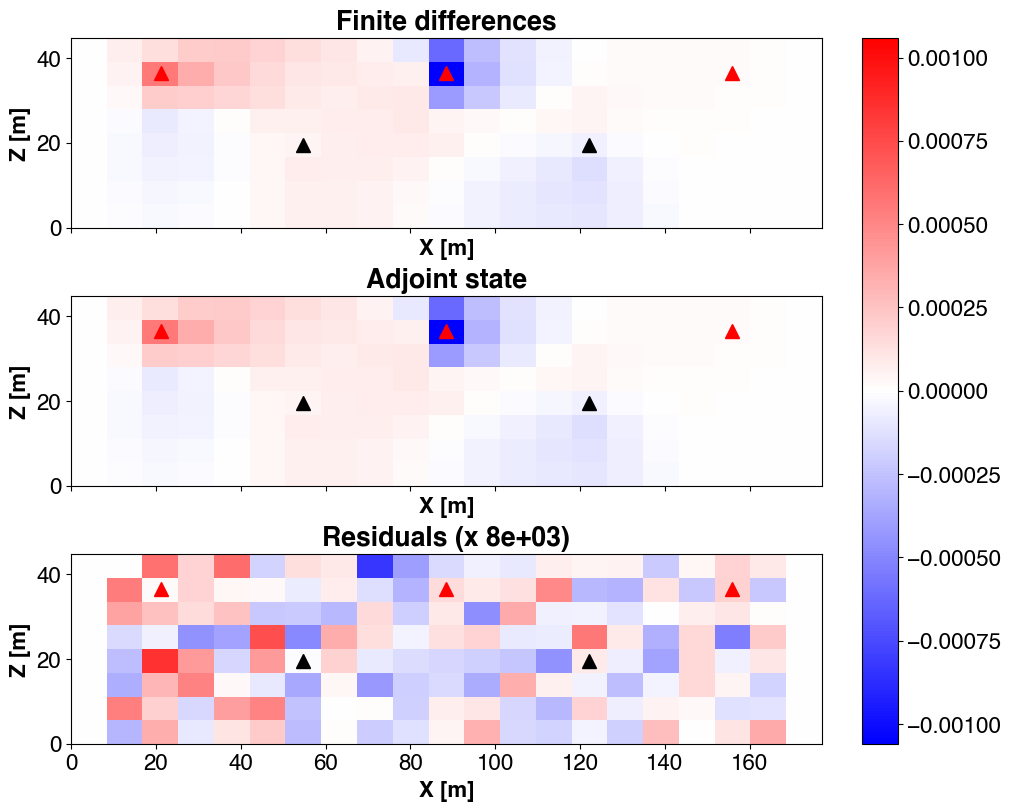

In [45]:
plot_2d_grad_res_adj_vs_fd(
    param_sc.grad_adj_history[0].reshape(nx, ny, order="F") * scaling_factor,
    param_sc.grad_fd_history[0].reshape(nx, ny, order="F") * scaling_factor,
    geometry,
    "perm",
    fig_save_path,
    prod_locations=production_locations,
    inj_locations=injection_locations,
)

## Gradient with respect to initial head

In [46]:
param_ih = dminv.AdjustableParameter(
    name=dminv.ParameterName.INITIAL_PRESSURE,
    lbounds=-2000000,
    ubounds=2000000,
)

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-15,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param_ih, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

executor.eval_scaled_loss(param_ih.preconditioner(param_ih.values))

is_grad_ok = executor.is_adjoint_gradient_correct(max_workers=4, is_verbose=False)

INFO:root:- Running forward model # 1


INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 1596.7701089483278
INFO:root:Loss (obs fit) / Nobs = 33.26604393642349
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.0006262642282667884
INFO:root:Loss (scaled)         = 1.0



In [47]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


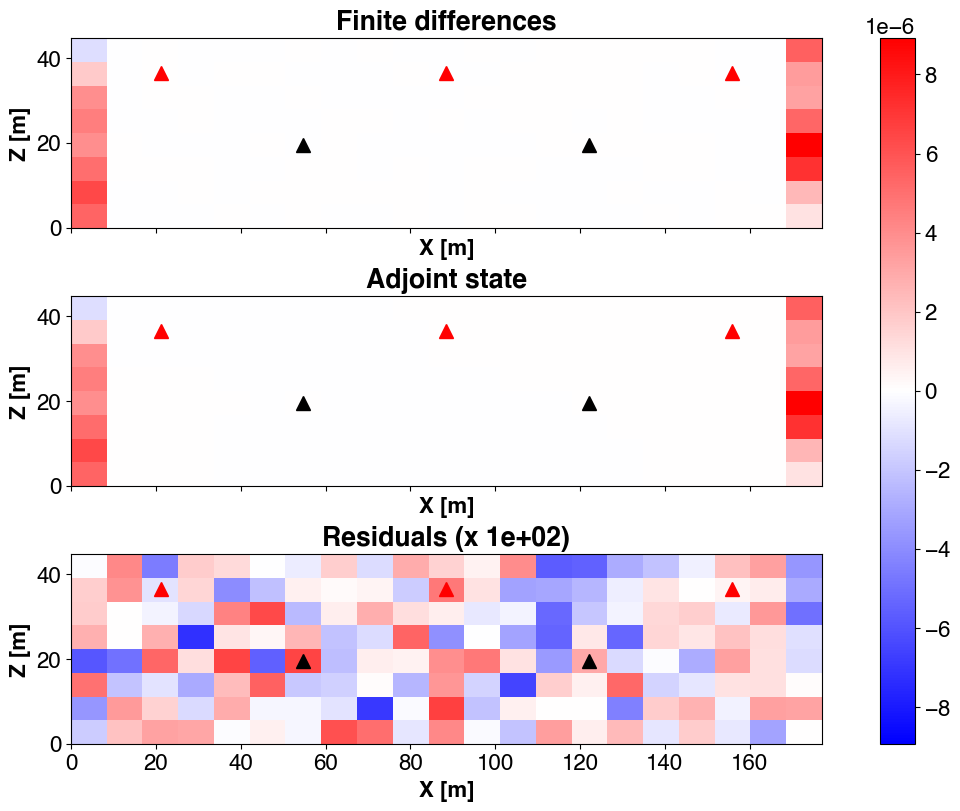

In [48]:
plot_2d_grad_res_adj_vs_fd(
    param_ih.grad_adj_history[0].reshape(nx, ny, order="F") * scaling_factor,
    param_ih.grad_fd_history[0].reshape(nx, ny, order="F") * scaling_factor,
    geometry,
    "perm",
    fig_save_path,
    prod_locations=production_locations,
    inj_locations=injection_locations,
)